In [6]:
# Cell 1: Imports & config 

import os
import json
import numpy as np
import pandas as pd

import networkx as nx

# Config

STEP1_SUMMARY_PATH = "/Users/pouriyasyd/Desktop/AP2 - Seyedpouria Seyedi/Data/step1_variable_summary.json"
CLEAN_DATA_PATH = "/Users/pouriyasyd/Desktop/AP2 - Seyedpouria Seyedi/Data/cleaned_predictive_maintenance.parquet"
CLEAN_DATA_FORMAT = "parquet"


# Output folder for this notebook
OUT_DIR = "outputs_step2"
os.makedirs(OUT_DIR, exist_ok=True)

print("STEP1_SUMMARY_PATH:", STEP1_SUMMARY_PATH)
print("CLEAN_DATA_PATH:", CLEAN_DATA_PATH)
print("OUT_DIR:", OUT_DIR)


STEP1_SUMMARY_PATH: /Users/pouriyasyd/Desktop/AP2 - Seyedpouria Seyedi/Data/step1_variable_summary.json
CLEAN_DATA_PATH: /Users/pouriyasyd/Desktop/AP2 - Seyedpouria Seyedi/Data/cleaned_predictive_maintenance.parquet
OUT_DIR: outputs_step2


In [7]:
# Cell 2: Load Step1 summary + cleaned dataset

# Load Step1 summary JSON
with open(STEP1_SUMMARY_PATH, "r") as f:
    step1_info = json.load(f)

# Load cleaned dataset
if CLEAN_DATA_FORMAT == "csv":
    df_clean = pd.read_csv(CLEAN_DATA_PATH)
elif CLEAN_DATA_FORMAT == "parquet":
    df_clean = pd.read_parquet(CLEAN_DATA_PATH)
else:
    raise ValueError("Unsupported CLEAN_DATA_FORMAT. Use 'csv' or 'parquet'.")

print("Loaded cleaned dataset shape:", df_clean.shape)

# Extract what we need
var_types_clean = step1_info["var_types_clean"]


# Sanity check: columns match JSON
missing_in_df = [c for c in var_types_clean.keys() if c not in df_clean.columns]
extra_in_df = [c for c in df_clean.columns if c not in var_types_clean.keys()]

print("\nSanity check:")
print("  Columns in JSON but missing in df_clean:", missing_in_df[:20], ("..." if len(missing_in_df) > 20 else ""))
print("  Columns in df_clean but missing in JSON:", extra_in_df[:20], ("..." if len(extra_in_df) > 20 else ""))

if len(missing_in_df) > 0:
    print("\nWARNING: Step1 JSON and df_clean columns do not match. You may be mixing files.")


Loaded cleaned dataset shape: (10000, 12)

Sanity check:
  Columns in JSON but missing in df_clean: [] 
  Columns in df_clean but missing in JSON: [] 


In [8]:
# Cell 3: Select columns for causal discovery

# Keep only columns still present in df_clean
var_types_clean = {k: v for k, v in var_types_clean.items() if k in df_clean.columns}

numeric_cols = [
    col for col, t in var_types_clean.items()
    if t in ("continuous", "discrete_numeric", "binary")
]

excluded_cols = [col for col in df_clean.columns if col not in numeric_cols]

print("Numeric columns used for causal discovery:")
print(numeric_cols)

if len(excluded_cols) > 0:
    print("\nExcluded columns (not numeric types):")
    print(excluded_cols)

df_num = df_clean[numeric_cols].copy()

# Force numeric conversion where possible (protect against object-coded numbers)
for col in df_num.columns:
    if not pd.api.types.is_numeric_dtype(df_num[col]):
        df_num[col] = pd.to_numeric(df_num[col], errors="coerce")

# Drop columns that became all-NaN after conversion 
all_nan_cols = [c for c in df_num.columns if df_num[c].isna().all()]
if len(all_nan_cols) > 0:
    print("\nDropping columns that became all-NaN after numeric conversion:", all_nan_cols)
    df_num.drop(columns=all_nan_cols, inplace=True)
    numeric_cols = [c for c in numeric_cols if c not in all_nan_cols]

# Replace inf with NaN then check remaining NaNs
df_num = df_num.replace([np.inf, -np.inf], np.nan)

if df_num.isnull().any().any():
    print("\nWARNING: NaNs found in df_num (should not happen after Step1).")
    print("NaNs per column:")
    display(df_num.isnull().sum())

# Drop zero-variance columns 
zero_var_cols = [c for c in df_num.columns if df_num[c].nunique(dropna=True) <= 1]
if len(zero_var_cols) > 0:
    print("\nDropping zero-variance columns:", zero_var_cols)
    df_num.drop(columns=zero_var_cols, inplace=True)
    numeric_cols = [c for c in numeric_cols if c not in zero_var_cols]

data = df_num.values  # numpy matrix (n x d)
subset_cols = list(df_num.columns)
d = len(subset_cols)

print(f"\nData matrix shape for causal discovery: {data.shape}")


Numeric columns used for causal discovery:
['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

Excluded columns (not numeric types):
['Type']

Data matrix shape for causal discovery: (10000, 11)


In [5]:
# Cell 4A: Helper functions

def adj_from_nx(nodes, g: nx.DiGraph):
    """
    Build adjacency matrix DataFrame (nodes x nodes),
    entry (i, j) = 1 if i -> j, else 0.
    Safe if g contains edges outside 'nodes' (they're ignored).
    """
    A = pd.DataFrame(0, index=nodes, columns=nodes, dtype=int)

    node_set = set(nodes)
    for u, v in g.edges():
        if (u in node_set) and (v in node_set):
            A.loc[u, v] = 1
    return A

def shd(A: pd.DataFrame, B: pd.DataFrame) -> int:
    """
    Directed SHD (entrywise Hamming distance) between two adjacency matrices A and B.
    Aligns to the union of nodes.
    NOTE: A reversal i->j vs j->i counts as 2.
    """
    if not isinstance(A, pd.DataFrame):
        A = pd.DataFrame(A)
    if not isinstance(B, pd.DataFrame):
        B = pd.DataFrame(B)

    all_nodes = sorted(set(A.index) | set(B.index))
    A2 = A.reindex(index=all_nodes, columns=all_nodes, fill_value=0)
    B2 = B.reindex(index=all_nodes, columns=all_nodes, fill_value=0)

    diff = (A2.values != B2.values)
    return int(diff.sum())

def skeleton_shd(A: pd.DataFrame, B: pd.DataFrame) -> int:
    """
    Skeleton SHD: ignores direction (treat edge i-j as undirected).
    A reversal counts as 0 difference in skeleton space.
    """
    if not isinstance(A, pd.DataFrame):
        A = pd.DataFrame(A)
    if not isinstance(B, pd.DataFrame):
        B = pd.DataFrame(B)

    all_nodes = sorted(set(A.index) | set(B.index))
    A2 = A.reindex(index=all_nodes, columns=all_nodes, fill_value=0).values
    B2 = B.reindex(index=all_nodes, columns=all_nodes, fill_value=0).values

    Au = ((A2 + A2.T) > 0).astype(int)
    Bu = ((B2 + B2.T) > 0).astype(int)

    diff = (Au != Bu)
    return int(diff.sum() // 2)  # divide by 2 because undirected edges appear twice

results_adj = {}      # name -> adjacency DataFrame
results_graph = {}    # name -> networkx DiGraph

# Warnings log + safe runner

warnings_log = []   # collect warnings/errors 

def log_warning(msg):
    print("WARNING:", msg)
    warnings_log.append(msg)

def safe_run(name, fn):
    """
    Run a block safely. If it fails, log and continue.
    Returns the function result, or None on failure.
    """
    try:
        return fn()
    except Exception as e:
        log_warning(f"{name} failed: {type(e).__name__}: {e}")
        return None


In [6]:
# Cell 4B: Utilities for Causal Discovery

import numpy as np
import pandas as pd
import networkx as nx

# A) Convert NetworkX graph → Adjacency DataFrame
def adj_from_nx(nodes, graph):
    A = pd.DataFrame(0, index=nodes, columns=nodes, dtype=np.int8)
    for u, v in graph.edges():
        if u in nodes and v in nodes:
            A.loc[u, v] = 1
    return A

# B) Enforce DAG by removing weakest edges in cycles
def make_dag_by_score(g_in, score_attr="score", default_score=0.0):
    g = nx.DiGraph()
    g.add_nodes_from(g_in.nodes())
    for u, v, d in g_in.edges(data=True):
        s = float(d.get(score_attr, default_score))
        g.add_edge(u, v, **{**d, score_attr: s})
    while not nx.is_directed_acyclic_graph(g):
        try:
            cycle = nx.find_cycle(g, orientation="original")
            weakest = min(cycle, key=lambda x: float(g.edges[x[0], x[1]].get(score_attr, default_score)))
            g.remove_edge(*weakest[:2])
        except:
            break
    return g

# C) Auto-detect variable roles (domain filtering)
def classify_variable_roles(df):
    roles = {}
    for col in df.columns:
        nunique = df[col].nunique(dropna=True)
        dtype = df[col].dtype
        if nunique <= 2:
            roles[col] = "binary"
        elif 2 < nunique <= 10:
            roles[col] = "categorical"
        elif np.issubdtype(dtype, np.number):
            roles[col] = "continuous"
        else:
            roles[col] = "other"
    return roles

# D) Select variable subset for discovery 
def choose_discovery_vars(roles_dict, keep_continuous_only=True):
    if keep_continuous_only:
        return [var for var, role in roles_dict.items() if role == "continuous"]
    else:
        return [var for var, role in roles_dict.items() if role in ("continuous", "categorical")]


In [7]:
# Cell 5A: NOTEARS 

import os, json, time
import numpy as np
import pandas as pd
import networkx as nx
from datetime import datetime
from joblib import Parallel, delayed
from causalnex.structure.notears import from_pandas

# A) Setup
ALG_NAME = "NOTEARS_BOOTSTRAPPED"
RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")
ALG_DIR = os.path.join(OUT_DIR, f"{ALG_NAME}_{RUN_TAG}")
os.makedirs(ALG_DIR, exist_ok=True)

K_RUNS      = 30
SAMPLE_FRAC = 0.65
SEED        = 42
N_JOBS      = 4
FREQ_THR    = 0.6
EDGE_Q      = 0.9
CAP_FACTOR  = 2.0
MIN_FACTOR  = 0.5
BOOTSTRAP   = True

print("ALG_DIR:", ALG_DIR)
print(f"{ALG_NAME} | K_RUNS={K_RUNS} | SAMPLE_FRAC={SAMPLE_FRAC} | FREQ_THR={FREQ_THR}")

# B) Automatic Variable Role Detection 
roles = {}
for col in df_num.columns:
    nunique = df_num[col].nunique(dropna=True)
    dtype   = df_num[col].dtype
    if nunique <= 2:
        roles[col] = "binary"
    elif 2 < nunique <= 10:
        roles[col] = "categorical"
    elif np.issubdtype(dtype, np.number):
        roles[col] = "continuous"
    else:
        roles[col] = "other"

subset_cols = [col for col, r in roles.items() if r == "continuous"]
print("Detected roles:", roles)
print("Selected vars:", subset_cols)

if len(subset_cols) < 2:
    raise ValueError("NOTEARS skipped — not enough continuous variables (need ≥2).")

df_notears = df_num[subset_cols].copy()
X = df_notears.to_numpy()
n, p = X.shape

# C) Helper: DAG enforcement
def make_dag_by_score(g_in, score_attr="score", default_score=0.0):
    g = nx.DiGraph()
    g.add_nodes_from(g_in.nodes())
    for u, v, d in g_in.edges(data=True):
        s = float(d.get(score_attr, default_score))
        g.add_edge(u, v, **{**d, score_attr: s})
    while not nx.is_directed_acyclic_graph(g):
        try:
            cycle = nx.find_cycle(g, orientation="original")
            weakest = min(cycle, key=lambda x: float(g.edges[x[0], x[1]].get(score_attr, default_score)))
            g.remove_edge(*weakest[:2])
        except:
            break
    return g

# D) Helper: adjacency converter
def adj_from_nx(columns, g):
    A = pd.DataFrame(0, index=columns, columns=columns, dtype=int)
    for u, v in g.edges():
        A.loc[u, v] = 1
    return A

# E) Bootstrapped runs
def one_run(k_idx):
    rng = np.random.default_rng(SEED + k_idx)
    idx = rng.choice(n, size=int(n * SAMPLE_FRAC), replace=BOOTSTRAP)
    df_k = pd.DataFrame(X[idx], columns=subset_cols)
    sm = from_pandas(df_k)

    edges = list(sm.edges(data=True))
    weights = np.array([abs(float(e[2].get("weight", 0.0))) for e in edges])

    if len(weights) == 0:
        return np.zeros((p, p)), {}, 0

    thr = np.quantile(weights, EDGE_Q)
    max_edges = int(CAP_FACTOR * p)
    min_edges = int(MIN_FACTOR * p)

    top = [e for e in edges if abs(float(e[2].get("weight", 0.0))) >= thr]
    top = sorted(top, key=lambda e: abs(float(e[2].get("weight", 0.0))), reverse=True)
    top = top[:max(min_edges, min(len(top), max_edges))]

    g = nx.DiGraph()
    g.add_nodes_from(subset_cols)
    for u, v, d in top:
        w = float(d.get("weight", 0.0))
        g.add_edge(u, v, weight=w)

    A = adj_from_nx(subset_cols, g).values.astype(np.int8)
    wmap = {(u, v): float(g.edges[u, v].get("weight", 0.0)) for u, v in g.edges()}
    return A, wmap, int(A.sum())

t0 = time.time()
outs = Parallel(n_jobs=N_JOBS)(delayed(one_run)(k) for k in range(K_RUNS))
print(f"Completed {K_RUNS} runs in {time.time() - t0:.1f} sec")



ALG_DIR: outputs_step2/NOTEARS_BOOTSTRAPPED_20260112_143151
NOTEARS_BOOTSTRAPPED | K_RUNS=30 | SAMPLE_FRAC=0.65 | FREQ_THR=0.6
Detected roles: {'Air temperature': 'continuous', 'Process temperature': 'continuous', 'Rotational speed': 'continuous', 'Torque': 'continuous', 'Tool wear': 'continuous', 'Machine failure': 'binary', 'TWF': 'binary', 'HDF': 'binary', 'PWF': 'binary', 'OSF': 'binary', 'RNF': 'binary'}
Selected vars: ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']
Completed 30 runs in 5.0 sec


In [10]:
# Cell 5B – Aggregate Results + Final Graph + Summary Table

# A) Gather matrices
A_list = [o[0] for o in outs]
w_maps = [o[1] for o in outs]

freq = np.mean(np.stack(A_list), axis=0)
edge_freq = pd.DataFrame(freq, index=subset_cols, columns=subset_cols)
edge_freq_path = os.path.join(ALG_DIR, "edge_freq_after_prune.csv")
edge_freq.to_csv(edge_freq_path)
print("Saved:", edge_freq_path)

# B) Collect edge weights across runs
weights_by_edge = {}
for wm in w_maps:
    for e, w in wm.items():
        weights_by_edge.setdefault(e, []).append(w)

rows = []
for u in subset_cols:
    for v in subset_cols:
        if u == v:
            continue
        f = float(edge_freq.loc[u, v])
        if f > 0:
            ws = weights_by_edge.get((u, v), [])
            rows.append({
                "source": u,
                "target": v,
                "freq": f,
                "n_present": int(round(f * K_RUNS)),
                "weight_median": float(np.median(ws)) if ws else 0.0,
                "abs_weight_median": float(np.median(np.abs(ws))) if ws else 0.0,
                "weight_mean": float(np.mean(ws)) if ws else 0.0,
            })

edge_stats = pd.DataFrame(rows).sort_values(
    ["freq", "abs_weight_median"], ascending=[False, False]
)
edge_stats_path = os.path.join(ALG_DIR, "edge_stats_freq_weight_NOTEARS.csv")
edge_stats.to_csv(edge_stats_path, index=False)
print("Saved:", edge_stats_path)

# C) Summary Table (Top 10 edges)
print("\n================ NOTEARS Summary ================")
print(f"Total candidate edges: {len(edge_stats)}")
print(f"K_RUNS={K_RUNS} | FREQ_THR={FREQ_THR} | EDGE_Q={EDGE_Q}\n")

print("Top 10 edges by freq and |median|:\n")
print(edge_stats.head(10).to_string(index=False))
print("\n=================================================\n")

# D) Final DAG by frequency threshold
keep = edge_stats[edge_stats["freq"] >= FREQ_THR]
print(f"Edges kept by freq >= {FREQ_THR}: {len(keep)}")

g_cons = nx.DiGraph()
g_cons.add_nodes_from(subset_cols)
for _, r in keep.iterrows():
    score = float(r["freq"]) + 1e-6 * float(r["abs_weight_median"])
    g_cons.add_edge(r["source"], r["target"],
                    freq=r["freq"],
                    weight_median=r["weight_median"],
                    abs_weight_median=r["abs_weight_median"],
                    score=score)

# E) Force DAG
g_final = make_dag_by_score(g_cons, score_attr="score")
A_final = adj_from_nx(subset_cols, g_final)

# F) Save Outputs
out_adj   = os.path.join(ALG_DIR, "FINAL_adj_NOTEARS.csv")
out_edges = os.path.join(ALG_DIR, "FINAL_edges_NOTEARS.csv")
out_graph = os.path.join(ALG_DIR, "FINAL_graph_NOTEARS.graphml")
out_json  = os.path.join(ALG_DIR, "FINAL_summary_NOTEARS.json")

A_final.to_csv(out_adj)
nx.write_graphml(g_final, out_graph)

pd.DataFrame([
    {
        "source": u,
        "target": v,
        "freq": d.get("freq", 0.0),
        "weight_median": d.get("weight_median", 0.0),
        "abs_weight_median": d.get("abs_weight_median", 0.0),
    }
    for u, v, d in g_final.edges(data=True)
]).to_csv(out_edges, index=False)

with open(out_json, "w") as f:
    json.dump({
        "algorithm": ALG_NAME,
        "K_RUNS": K_RUNS,
        "SAMPLE_FRAC": SAMPLE_FRAC,
        "EDGE_Q": EDGE_Q,
        "FREQ_THR": FREQ_THR,
        "BOOTSTRAP": BOOTSTRAP,
        "final_edge_count": int(g_final.number_of_edges()),
    }, f, indent=2)

# G) Register to Pipeline
results_graph[ALG_NAME] = g_final
results_adj[ALG_NAME]   = A_final

print("Saved outputs:\n", out_adj, "\n", out_edges, "\n", out_graph, "\n", out_json)


Saved: outputs_step2/NOTEARS_BOOTSTRAPPED_20260112_143151/edge_freq_after_prune.csv
Saved: outputs_step2/NOTEARS_BOOTSTRAPPED_20260112_143151/edge_stats_freq_weight_NOTEARS.csv

================ NOTEARS Summary ================
Total candidate edges: 4
K_RUNS=30 | FREQ_THR=0.6 | EDGE_Q=0.9

Top 10 edges by freq and |median|:

             source              target     freq  n_present  weight_median  abs_weight_median  weight_mean
    Air temperature Process temperature 0.666667         20       0.878357           0.878357     0.878547
   Rotational speed              Torque 0.600000         18      -0.900824           0.900824    -0.901061
             Torque    Rotational speed 0.400000         12      -0.900167           0.900167    -0.901019
Process temperature     Air temperature 0.333333         10       0.878890           0.878890     0.877863


Edges kept by freq >= 0.6: 2
Saved outputs:
 outputs_step2/NOTEARS_BOOTSTRAPPED_20260112_143151/FINAL_adj_NOTEARS.csv 
 outputs_step2/N

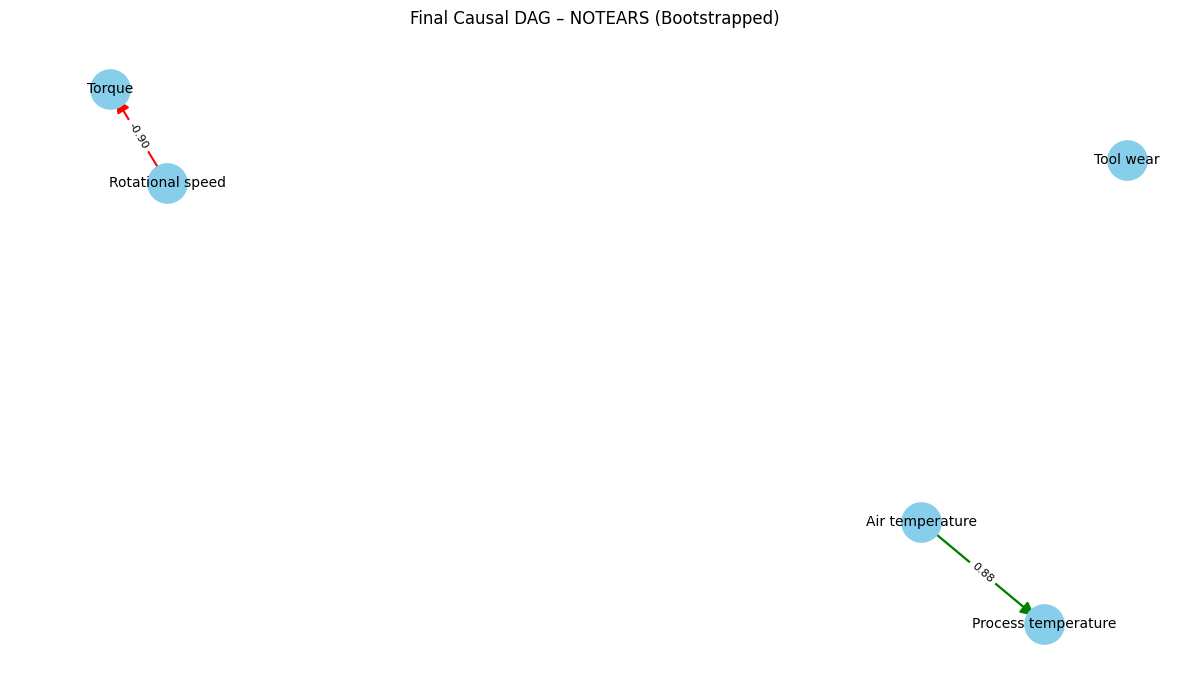

In [11]:
# Cell 5C – Visualize Final NOTEARS DAG

import networkx as nx
import matplotlib.pyplot as plt

GRAPH_PATH = os.path.join(ALG_DIR, "FINAL_graph_NOTEARS.graphml")

if not os.path.exists(GRAPH_PATH):
    print("NOTEARS DAG plot skipped: FINAL_graph_NOTEARS.graphml not found.")
else:
    G = nx.read_graphml(GRAPH_PATH)

    for u, v, data in G.edges(data=True):
        for k in ["weight_median", "freq"]:
            try:
                data[k] = float(data.get(k, 0.0))
            except:
                data[k] = 0.0

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12,7))
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color='skyblue')
    nx.draw_networkx_labels(G, pos, font_size=10)

    edge_colors = ['green' if G[u][v].get('weight_median', 0.0) > 0 else 'red' 
                   for u, v in G.edges()]
    edge_widths = [2.5 * G[u][v].get('freq', 1.0) for u, v in G.edges()]

    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, arrowsize=20)

    edge_labels = {(u, v): f"{G[u][v].get('weight_median', 0.0):.2f}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Final Causal DAG – NOTEARS (Bootstrapped)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [12]:
# Cell 6A — GES Setup

import os
import json
import numpy as np
import pandas as pd
from datetime import datetime

from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.GraphUtils import GraphUtils

# A) Configure Experiment

ALG_NAME = "GES_Bootstrap"
RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")
ALG_DIR = os.path.join("outputs_step2", f"{ALG_NAME}_{RUN_TAG}")
os.makedirs(ALG_DIR, exist_ok=True)

print(f"Running {ALG_NAME}...")
print(f"Output directory: {ALG_DIR}")

# B) Variable Role Classification

def classify_variable_roles(df):
    roles = {}
    n = len(df)
    for col in df.columns:
        nunique = df[col].nunique()
        ratio = nunique / n

        if nunique <= 2 or ratio < 0.02:
            roles[col] = "binary_outcome"
        elif nunique <= 10 or ratio < 0.05:
            roles[col] = "categorical"
        elif pd.api.types.is_numeric_dtype(df[col]):
            roles[col] = "continuous"
        else:
            roles[col] = "unknown"
    return roles

def choose_discovery_vars(roles, keep_continuous_only=True):
    if keep_continuous_only:
        return [c for c, r in roles.items() if r == "continuous"]
    else:
        return [c for c in roles.keys()]  # allow all if user wants


# C) Apply Domain Filtering

roles = classify_variable_roles(df_num)
subset_cols = choose_discovery_vars(roles, keep_continuous_only=True)

print(f"Detected roles: {roles}")
print(f"Selected variables for GES: {subset_cols}")

if len(subset_cols) < 2:
    print(" GES Bootstrap skipped — not enough continuous variables (need ≥2).")
    df_ges = None
else:
    df_ges = df_num[subset_cols].copy()
    print(f"Dataset for GES shape: {df_ges.shape}")

# D) Bootstrapping Configuration

BOOT_RUNS = 30        # Number of bootstrap runs
BOOT_FRAC = 0.70      # Sampling fraction
SEED = 42
np.random.seed(SEED)

print(f"Bootstrap Config: RUNS={BOOT_RUNS}, FRAC={BOOT_FRAC}, SEED={SEED}")

# Register pipeline dicts if missing
if 'results_graph' not in globals():
    results_graph = {}
if 'results_adj' not in globals():
    results_adj = {}

print("Cell 6A setup complete.")


Running GES_Bootstrap...
Output directory: outputs_step2/GES_Bootstrap_20260112_143232
Detected roles: {'Air temperature': 'binary_outcome', 'Process temperature': 'binary_outcome', 'Rotational speed': 'continuous', 'Torque': 'categorical', 'Tool wear': 'categorical', 'Machine failure': 'binary_outcome', 'TWF': 'binary_outcome', 'HDF': 'binary_outcome', 'PWF': 'binary_outcome', 'OSF': 'binary_outcome', 'RNF': 'binary_outcome'}
Selected variables for GES: ['Rotational speed']
 GES Bootstrap skipped — not enough continuous variables (need ≥2).
Bootstrap Config: RUNS=30, FRAC=0.7, SEED=42
Cell 6A setup complete.


In [13]:
# Cell 6B - GES Bootstrap + Edge Stability

import networkx as nx
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

if df_ges is None:
    print("Skipping GES bootstrap: df_ges is not available.")
else:
    edge_counter = defaultdict(int)
    edge_scores = defaultdict(list)

    X_data = df_ges.to_numpy()
    n_samples = len(X_data)
    var_names = list(df_ges.columns)

    print(f"Running {BOOT_RUNS} bootstraps for GES...")
    for i in tqdm(range(BOOT_RUNS)):
        sample_idx = np.random.choice(n_samples, int(BOOT_FRAC * n_samples), replace=True)
        X_boot = X_data[sample_idx]

        try:
            result = ges(X_boot)
            G = result['G']
            edges = G.graph.keys()

            for u, v in edges:
                src, tgt = var_names[u], var_names[v]
                score = G.graph[(u, v)]
                edge_counter[(src, tgt)] += 1
                edge_scores[(src, tgt)].append(score)
        except Exception as e:
            print(f"Bootstrap {i+1} failed:", str(e))

    # Final stable edges (appeared in ≥40% of runs)
    stable_edges = []
    for (src, tgt), freq in edge_counter.items():
        rel_freq = freq / BOOT_RUNS
        if rel_freq >= 0.4:
            scores = edge_scores[(src, tgt)]
            median_score = np.median(scores)
            stable_edges.append({
                "source": src,
                "target": tgt,
                "freq": round(rel_freq, 2),
                "median_score": round(median_score, 5)
            })

    stable_df = pd.DataFrame(stable_edges)
    stable_df = stable_df.sort_values("freq", ascending=False)

    # Save outputs
    edges_out = os.path.join(ALG_DIR, "STABLE_edges_GES.csv")
    stable_df.to_csv(edges_out, index=False)

    print(f"GES Bootstrapping complete. Stable edges saved to: {edges_out}")
    print("Top edges:\n", stable_df.head(10).to_string(index=False))

    # Visual: Frequency Histogram
    plt.figure(figsize=(6, 4))
    plt.hist([e["freq"] for e in stable_edges], bins=10, edgecolor='black', color='slateblue')
    plt.title("GES Edge Stability Across Bootstraps")
    plt.xlabel("Edge Frequency")
    plt.ylabel("Count")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


Skipping GES bootstrap: df_ges is not available.


In [14]:
# Cell 6C — Plot Stable GES DAG

import networkx as nx
import matplotlib.pyplot as plt
import os

STABLE_PATH = os.path.join(ALG_DIR, "STABLE_edges_GES.csv")

if not os.path.exists(STABLE_PATH):
    print("DAG plot skipped: STABLE_edges_GES.csv not found.")
else:
    df_stable = pd.read_csv(STABLE_PATH)

    if df_stable.empty:
        print("No stable edges found for plotting.")
    else:
        # Create directed graph
        G_stable = nx.DiGraph()
        for _, row in df_stable.iterrows():
            G_stable.add_edge(
                row["source"], row["target"],
                score=row["median_score"],
                freq=row["freq"]
            )

        # Layout
        pos = nx.spring_layout(G_stable, seed=42)

        # Draw nodes
        plt.figure(figsize=(12, 7))
        nx.draw_networkx_nodes(G_stable, pos, node_color="lightblue", node_size=1000)
        nx.draw_networkx_labels(G_stable, pos, font_size=10)

        # Draw edges
        edge_weights = [abs(G_stable[u][v]["score"]) for u, v in G_stable.edges()]
        edge_colors = ["green" if G_stable[u][v]["score"] >= 0 else "red" for u, v in G_stable.edges()]
        edge_widths = [2 + 3 * w for w in edge_weights]

        nx.draw_networkx_edges(
            G_stable, pos,
            edge_color=edge_colors,
            width=edge_widths,
            arrowsize=20
        )

        # Draw edge labels (median score)
        edge_labels = {
            (u, v): f"{G_stable[u][v]['score']:.2f}" for u, v in G_stable.edges()
        }
        nx.draw_networkx_edge_labels(G_stable, pos, edge_labels=edge_labels, font_size=8)

        plt.title("Stable Causal DAG (GES + Bootstrapping)")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


DAG plot skipped: STABLE_edges_GES.csv not found.


In [15]:
# Cell 7A – LiNGAM Setup

import os
import json
import numpy as np
import pandas as pd
import networkx as nx
from datetime import datetime
from lingam import DirectLiNGAM

# A) Config
ALG_NAME = "DirectLiNGAM_Bootstrap"
RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")
ALG_DIR = os.path.join("outputs_step2", f"{ALG_NAME}_{RUN_TAG}")
os.makedirs(ALG_DIR, exist_ok=True)

N_BOOT = 30
FREQ_THRESHOLD = 0.1

print(f"Running {ALG_NAME}...\nOutput directory: {ALG_DIR}")

# B) Auto role detection 
roles = {}
for col in df_num.columns:
    nunique = df_num[col].nunique(dropna=True)
    dtype = df_num[col].dtype

    if nunique <= 2:
        roles[col] = "binary"
    elif 2 < nunique <= 10:
        roles[col] = "categorical"
    elif np.issubdtype(dtype, np.number):
        roles[col] = "continuous"
    else:
        roles[col] = "other"

# C) Select only continuous numeric variables
continuous_cols = [col for col, role in roles.items() if role == "continuous"]

print(" Variable Roles:")
for col, role in roles.items():
    print(f"  {col}: {role}")

if len(continuous_cols) < 2:
    print(" Not enough continuous variables (≥2 required). Skipping LiNGAM.")
    df_lingam = None
else:
    df_lingam = df_num[continuous_cols].copy()
    print(f"\n Using {len(continuous_cols)} continuous variables for LiNGAM:")
    print("   ", continuous_cols)


Running DirectLiNGAM_Bootstrap...
Output directory: outputs_step2/DirectLiNGAM_Bootstrap_20260112_143354
 Variable Roles:
  Air temperature: continuous
  Process temperature: continuous
  Rotational speed: continuous
  Torque: continuous
  Tool wear: continuous
  Machine failure: binary
  TWF: binary
  HDF: binary
  PWF: binary
  OSF: binary
  RNF: binary

 Using 5 continuous variables for LiNGAM:
    ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']


In [16]:
# Cell 7B – Run Bootstrapped LiNGAM

if df_lingam is None:
    print("Skipping: df_lingam is None.")
else:
    try:
        X_full = df_lingam.values
        cols = df_lingam.columns.tolist()
        edge_records = {}

        for i in range(N_BOOT):
            idx = np.random.choice(len(X_full), size=len(X_full), replace=True)
            model = DirectLiNGAM()
            model.fit(X_full[idx])
            B = model.adjacency_matrix_

            for i, src in enumerate(cols):
                for j, tgt in enumerate(cols):
                    if abs(B[i, j]) > 1e-6:
                        edge_records.setdefault((src, tgt), []).append(B[i, j])

        # A) Aggregate results
        edge_list = []
        for (src, tgt), weights in edge_records.items():
            edge_list.append({
                "source": src,
                "target": tgt,
                "freq": round(len(weights) / N_BOOT, 2),
                "weight_median": np.median(weights),
                "abs_weight_median": abs(np.median(weights))
            })
        edges_df = pd.DataFrame(edge_list)

        # B) Filter by frequency
        edges_df = edges_df[edges_df["freq"] >= FREQ_THRESHOLD]

        # C) Resolve bidirectional conflicts
        edges_df = edges_df.sort_values("abs_weight_median", ascending=False)
        unique_edges = {}
        for _, r in edges_df.iterrows():
            if (r["target"], r["source"]) in unique_edges:
                existing = unique_edges[(r["target"], r["source"])]
                if r["freq"] > existing["freq"]:
                    del unique_edges[(r["target"], r["source"])]
                    unique_edges[(r["source"], r["target"])] = r
            else:
                unique_edges[(r["source"], r["target"])] = r

        edges_df = pd.DataFrame(list(unique_edges.values()))

        # D) Build final graph
        G = nx.DiGraph()
        G.add_nodes_from(cols)
        for _, row in edges_df.iterrows():
            G.add_edge(row["source"], row["target"],
                       weight_median=row["weight_median"],
                       freq=row["freq"])

        # E) Save outputs
        A_df = pd.DataFrame(0, index=cols, columns=cols)
        for u, v in G.edges():
            A_df.loc[u, v] = 1

        A_df.to_csv(os.path.join(ALG_DIR, "FINAL_adj_LiNGAM_Bootstrap.csv"))
        edges_df.to_csv(os.path.join(ALG_DIR, "FINAL_edges_LiNGAM_Bootstrap.csv"), index=False)
        nx.write_graphml(G, os.path.join(ALG_DIR, "FINAL_graph_LiNGAM_Bootstrap.graphml"))

        with open(os.path.join(ALG_DIR, "FINAL_summary_LiNGAM_Bootstrap.json"), "w") as f:
            json.dump({
                "algorithm": ALG_NAME,
                "bootstraps": N_BOOT,
                "freq_threshold": FREQ_THRESHOLD,
                "n_edges": len(edges_df),
                "n_vars": len(cols),
                "vars_used": cols
            }, f, indent=2)

        results_graph[ALG_NAME] = G
        results_adj[ALG_NAME] = A_df

        print(f"\n{ALG_NAME} finished. Edges: {len(edges_df)} | Variables: {len(cols)}")
        print("Top edges by |median weight|:")
        for _, row in edges_df.sort_values("abs_weight_median", ascending=False).head(10).iterrows():
            print(f"  {row['source']} → {row['target']} | freq = {row['freq']} | median = {row['weight_median']:.4f}")

    except Exception as e:
        print("Error during LiNGAM:", str(e))



DirectLiNGAM_Bootstrap finished. Edges: 3 | Variables: 5
Top edges by |median weight|:
  Torque → Rotational speed | freq = 1.0 | median = -0.8950
  Process temperature → Air temperature | freq = 1.0 | median = 0.8743
  Air temperature → Rotational speed | freq = 0.17 | median = 0.0344


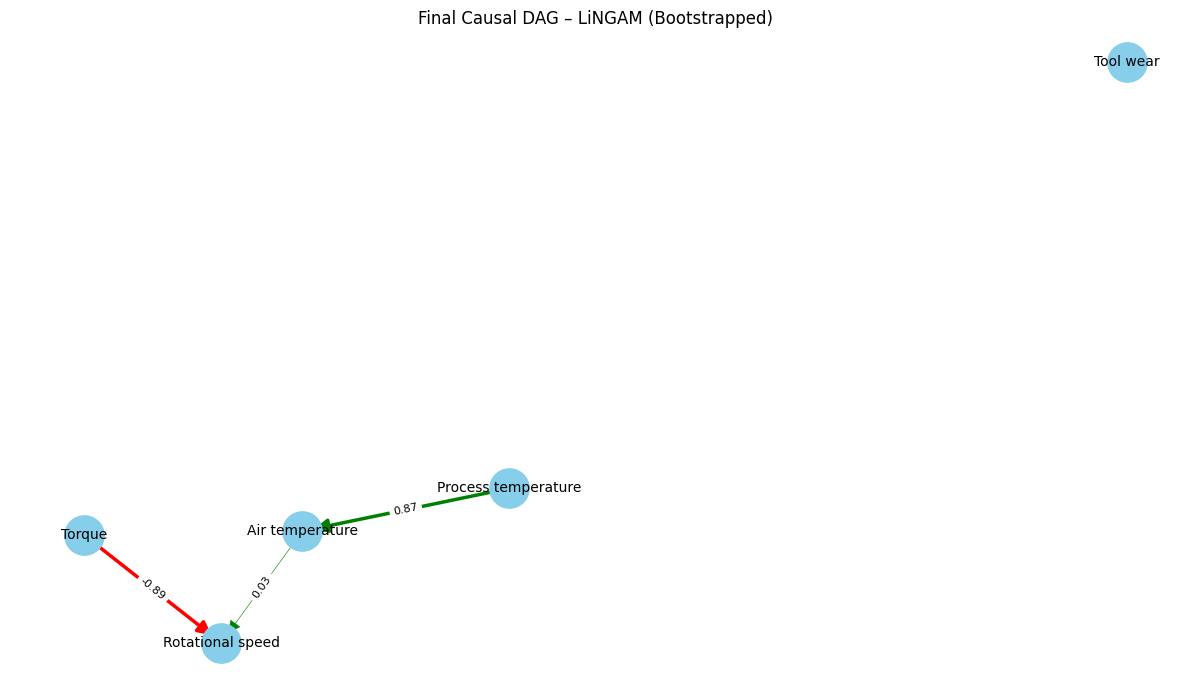

In [17]:
# Cell 7C – Visualize Final LiNGAM DAG

GRAPH_PATH = os.path.join(ALG_DIR, "FINAL_graph_LiNGAM_Bootstrap.graphml")

if not os.path.exists(GRAPH_PATH):
    print(" Graph file not found.")
else:
    G = nx.read_graphml(GRAPH_PATH)

    for u, v, d in G.edges(data=True):
        d["freq"] = float(d.get("freq", 0.0))
        d["weight_median"] = float(d.get("weight_median", 0.0))

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 7))
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
    nx.draw_networkx_labels(G, pos, font_size=10)

    edge_colors = ['green' if d["weight_median"] > 0 else 'red' for _, _, d in G.edges(data=True)]
    edge_widths = [2.5 * d["freq"] for _, _, d in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, arrowsize=20)

    edge_labels = {(u, v): f"{d['weight_median']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Final Causal DAG – LiNGAM (Bootstrapped)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [96]:
# Cell 8A – Setup for DAG-GNN 

import os, json
import numpy as np
import pandas as pd
import networkx as nx
import torch
import random
from datetime import datetime

from torch import optim
import torch.nn as nn

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# A) Classify Variables
def classify_variable_roles(df):
    roles = {}
    for col in df.columns:
        nunique = df[col].nunique(dropna=True)
        if nunique <= 2:
            roles[col] = "binary_outcome"
        elif 2 < nunique <= 10:
            roles[col] = "categorical"
        elif pd.api.types.is_numeric_dtype(df[col]):
            roles[col] = "continuous"
        else:
            roles[col] = "unknown"
    return roles

def choose_discovery_vars(roles, drop_outcomes=True):
    return [
        col for col, role in roles.items()
        if role == "continuous" and not (drop_outcomes and role in ["binary_outcome", "categorical"])
    ]

# B) Setup Paths
ALG_NAME = "DAG_GNN_Bootstrap"
RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")
ALG_DIR = os.path.join("outputs_step2", f"{ALG_NAME}_{RUN_TAG}")
os.makedirs(ALG_DIR, exist_ok=True)

# C) Variable Selection
roles = classify_variable_roles(df_num)
subset_cols = choose_discovery_vars(roles)

if len(subset_cols) < 2:
    print(f"{ALG_NAME} skipped: Not enough continuous variables (need ≥2).")
    df_daggnn = None
else:
    df_daggnn = df_num[subset_cols].copy()
    print(f"{ALG_NAME} will use {len(subset_cols)} variables.")
    print(" Selected variables:", subset_cols)


DAG_GNN_Bootstrap will use 5 variables.
 Selected variables: ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']


In [98]:
# Cell 8B – Bootstrapped DAG-GNN Discovery 

if len(subset_cols) < 2:
    print(f"{ALG_NAME} skipped: Not enough continuous variables (need ≥2).")
else:
    try:
        print(f"Bootstrapping DAG-GNN with stronger model (hidden_dim=128, iters=500, lam=0.0001)")

        N_BOOT = 30
        X_full = df_num[subset_cols].copy().values.astype(np.float32)
        edge_records = {}

        def train_daggnn_boosted(X, lr=0.01, n_iters=500, lam=0.0001):
            class DAGGNNModel(nn.Module):
                def __init__(self, d_in, hidden_dim=128):
                    super().__init__()
                    self.fc1 = nn.Linear(d_in, hidden_dim)
                    self.fc2 = nn.Linear(hidden_dim, d_in)

                def forward(self, X):
                    h = torch.relu(self.fc1(X))
                    return self.fc2(h)

            d = X.shape[1]
            model = DAGGNNModel(d)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            X_tensor = torch.from_numpy(X).float()

            for _ in range(n_iters):
                optimizer.zero_grad()
                pred = model(X_tensor)
                loss = torch.mean((X_tensor - pred) ** 2)
                loss += lam * sum(torch.abs(p).sum() for p in model.parameters())
                loss.backward()
                optimizer.step()

            with torch.no_grad():
                W_est = model.fc2.weight.detach().cpu().numpy().T
            return W_est

        for i in range(N_BOOT):
            sample_idx = np.random.choice(len(X_full), size=len(X_full), replace=True)
            X_boot = X_full[sample_idx]
            W_est = train_daggnn_boosted(X_boot)

            for i, u in enumerate(subset_cols):
                for j, v in enumerate(subset_cols):
                    if i == j:
                        continue
                    w = float(W_est[i, j])
                    if abs(w) >= 0.01:
                        key = (u, v)
                        if key not in edge_records:
                            edge_records[key] = []
                        edge_records[key].append(w)

        # Summary edge list
        edge_list = []
        for (u, v), weights in edge_records.items():
            edge_list.append({
                "source": u,
                "target": v,
                "freq": round(len(weights) / N_BOOT, 2),
                "weight_mean": np.mean(weights),
                "weight_median": np.median(weights),
                "abs_weight_median": abs(np.median(weights))
            })

        edges_df = pd.DataFrame(edge_list)
        edges_df = edges_df[edges_df["freq"] >= 0.2]
        edges_df = edges_df.sort_values("abs_weight_median", ascending=False)

        # Build graph
        G = nx.DiGraph()
        G.add_nodes_from(subset_cols)
        for _, row in edges_df.iterrows():
            G.add_edge(row["source"], row["target"],
                       weight_median=row["weight_median"],
                       freq=row["freq"])

        # Save
        A_df = pd.DataFrame(0, index=subset_cols, columns=subset_cols)
        for u, v in G.edges():
            A_df.loc[u, v] = 1

        out_adj = os.path.join(ALG_DIR, "FINAL_adj_DAG-GNN_Bootstrap.csv")
        out_edges = os.path.join(ALG_DIR, "FINAL_edges_DAG-GNN_Bootstrap.csv")
        out_graph = os.path.join(ALG_DIR, "FINAL_graph_DAG-GNN_Bootstrap.graphml")
        out_json = os.path.join(ALG_DIR, "FINAL_summary_DAG-GNN_Bootstrap.json")

        A_df.to_csv(out_adj)
        edges_df.to_csv(out_edges, index=False)
        nx.write_graphml(G, out_graph)

        with open(out_json, "w") as f:
            json.dump({
                "algorithm": ALG_NAME,
                "variant": "Bootstrapped + Boosted",
                "n_edges": len(edges_df),
                "n_vars": len(subset_cols),
                "bootstraps": N_BOOT,
                "vars_used": subset_cols
            }, f, indent=2)

        results_graph[ALG_NAME] = G
        results_adj[ALG_NAME] = A_df

        print(f" Bootstrapped DAG-GNN finished. Edges: {len(edges_df)} | Variables: {len(subset_cols)}")
        print(" Top edges by |median weight|:")
        for _, row in edges_df.head(10).iterrows():
            print(f"  {row['source']} → {row['target']} | freq = {row['freq']} | median = {row['weight_median']:.4f}")

    except Exception as e:
        print(f" Bootstrapped DAG-GNN failed:", str(e))


Bootstrapping DAG-GNN with stronger model (hidden_dim=128, iters=500, lam=0.0001)
 Bootstrapped DAG-GNN finished. Edges: 20 | Variables: 5
 Top edges by |median weight|:
  Air temperature → Tool wear | freq = 0.33 | median = 0.1210
  Process temperature → Tool wear | freq = 0.43 | median = 0.1130
  Air temperature → Torque | freq = 0.33 | median = 0.0823
  Air temperature → Rotational speed | freq = 0.43 | median = -0.0701
  Process temperature → Torque | freq = 0.43 | median = 0.0681
  Torque → Air temperature | freq = 0.5 | median = 0.0617
  Rotational speed → Tool wear | freq = 0.6 | median = -0.0602
  Rotational speed → Process temperature | freq = 0.57 | median = 0.0581
  Tool wear → Air temperature | freq = 0.47 | median = -0.0562
  Rotational speed → Air temperature | freq = 0.53 | median = 0.0534


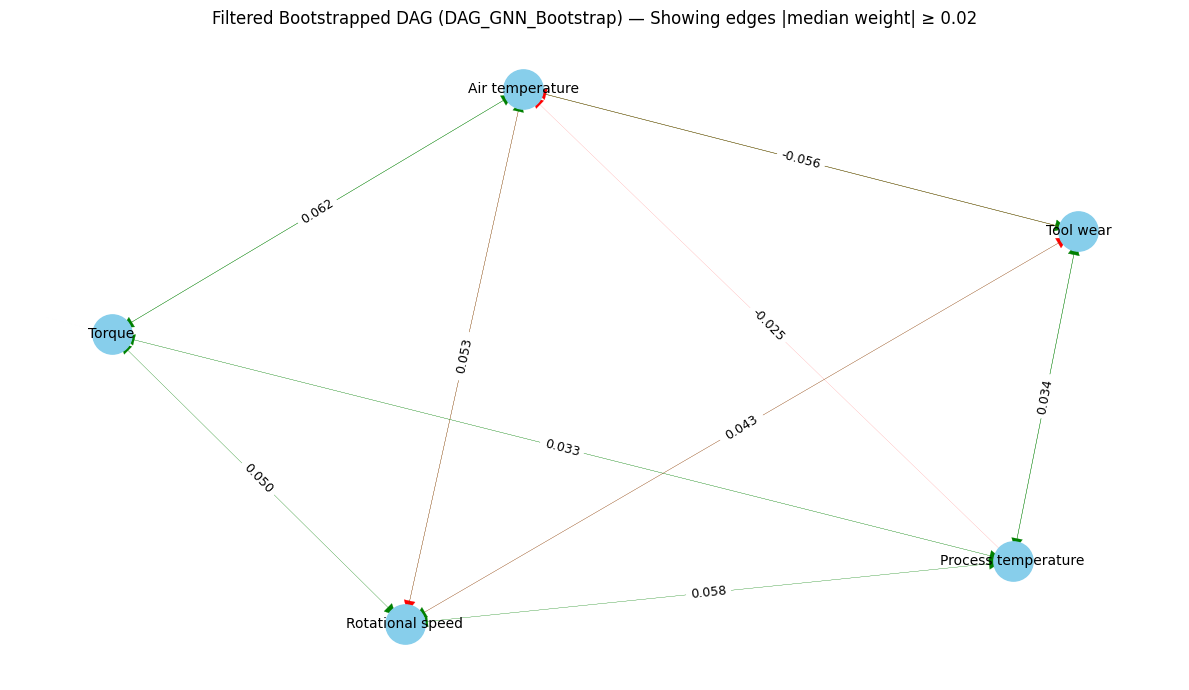

In [99]:
# Cell 8C – Visualize Final DAG-GNN Graph 

import matplotlib.pyplot as plt
import networkx as nx

ALG_NAME = "DAG_GNN_Bootstrap"
G = results_graph[ALG_NAME]

# Threshold used earlier
min_weight_display = 0.02  # edges shown only if |median weight| ≥ this

# Filter edges
edges_to_draw = [(u, v) for u, v, d in G.edges(data=True)
                 if abs(d.get("weight_median", 0)) >= min_weight_display]

# Layout
pos = nx.spring_layout(G, seed=42)

# Plot
plt.figure(figsize=(12, 7))
nx.draw_networkx_nodes(G, pos, node_size=800, node_color="skyblue")
nx.draw_networkx_labels(G, pos, font_size=10)

# Draw filtered edges only
edge_colors = ['green' if G[u][v]["weight_median"] > 0 else 'red' for u, v in edges_to_draw]
edge_widths = [3 * abs(G[u][v]["weight_median"]) for u, v in edges_to_draw]
nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, edge_color=edge_colors,
                       width=edge_widths, arrowsize=20)

# Edge labels (rounded median weight)
edge_labels = {(u, v): f'{G[u][v]["weight_median"]:.3f}' for u, v in edges_to_draw}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title(f"Filtered Bootstrapped DAG ({ALG_NAME}) — Showing edges |median weight| ≥ {min_weight_display}")
plt.axis("off")
plt.tight_layout()
plt.show()


In [19]:
# Cell 9A – Setup for PC (Bootstrapped, Domain-Aware)

import os, json
import numpy as np
import pandas as pd
import networkx as nx
from datetime import datetime
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz

# A) Setup Output Directory
ALG_NAME = "PC_Bootstrap"
RUN_TAG = datetime.now().strftime("%Y%m%d_%H%M%S")
ALG_DIR = os.path.join("outputs_step2", f"{ALG_NAME}_{RUN_TAG}")
os.makedirs(ALG_DIR, exist_ok=True)

print(f"Running 30 bootstraps for PC... Output dir: {ALG_DIR}")

# B) Domain-Aware Variable Classification
def classify_variable_roles(df):
    roles = {}
    for col in df.columns:
        nunique = df[col].nunique(dropna=True)
        if nunique <= 2:
            roles[col] = "binary_outcome"
        elif 2 < nunique <= 10:
            roles[col] = "categorical"
        elif pd.api.types.is_numeric_dtype(df[col]):
            roles[col] = "continuous"
        else:
            roles[col] = "unknown"
    return roles

roles = classify_variable_roles(df_num)
subset_cols = [col for col, role in roles.items() if role == "continuous"]

if len(subset_cols) < 2:
    print(f"{ALG_NAME} skipped: Not enough continuous variables (need ≥2).")
    df_pc = None
else:
    df_pc = df_num[subset_cols].copy()
    print(f"{ALG_NAME} will use {len(subset_cols)} variables.")
    print("   Selected variables:", subset_cols)


Running 30 bootstraps for PC... Output dir: outputs_step2/PC_Bootstrap_20260112_145918
PC_Bootstrap will use 5 variables.
   Selected variables: ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']


In [20]:
# Cell 9B – Bootstrapped PC Discovery + Stability

if df_pc is None:
    print(f" {ALG_NAME} skipped – no usable variables.")
else:
    try:
        from scipy.stats import pearsonr

        N_BOOT = 30
        FREQ_THRESHOLD = 0.30   # keep edges seen ≥30% of the time

        # Optional domain-based exclusions
        DOMAIN_EXCLUDE_VARS = set()  # e.g.: {"Machine failure", "Defect Rate"}
        DOMAIN_INVALID_EDGES = set()  # e.g.: {("X","Y"), ("A","B")}

        cols = [c for c in subset_cols if c not in DOMAIN_EXCLUDE_VARS]
        X_full = df_pc[cols].values

        edge_records = {}

        print(f"Bootstrapping {N_BOOT} runs for PC...")

        for b in range(N_BOOT):
            idx = np.random.choice(len(X_full), len(X_full), replace=True)
            X_boot = X_full[idx]

            # Run PC
            cg = pc(data=X_boot, alpha=0.3, indep_test=fisherz,
                    uc_rule=0, verbose=False)

            adj = cg.G.graph
            n = adj.shape[0]

            # Collect oriented edges
            for i in range(n):
                for j in range(n):
                    if adj[i, j] == 1:
                        u, v = cols[i], cols[j]
                        if (u, v) in DOMAIN_INVALID_EDGES:
                            continue
                        edge_records.setdefault((u, v), 0)
                        edge_records[(u, v)] += 1

        # Compute normalized edge frequencies
        edge_freq = {k: v / N_BOOT for k, v in edge_records.items()}

        print(f"Found {len(edge_freq)} unique directed edges across bootstraps.")

        # Compute correlation as strength 
        edge_strength = {}
        for (u, v), f in edge_freq.items():
            try:
                corr, _ = pearsonr(df_pc[u], df_pc[v])
            except Exception:
                corr = 0.0
            edge_strength[(u, v)] = corr

        # Build DataFrame with stability info
        edges_df = pd.DataFrame([
            {
                "source": u,
                "target": v,
                "freq": edge_freq[(u, v)],
                "corr": edge_strength[(u, v)],
                "abs_corr": abs(edge_strength[(u, v)])
            }
            for (u, v) in edge_freq.keys()
            if edge_freq[(u, v)] >= FREQ_THRESHOLD
        ])

        if edges_df.empty:
            print("⚠ No stable edges above frequency threshold.")
        else:
            edges_df = edges_df.sort_values(["freq", "abs_corr"], ascending=[False, False])
            print("\nStable PC edges (freq ≥ {0}): {1}".format(FREQ_THRESHOLD, len(edges_df)))
            print(edges_df.head(10).to_string(index=False))

        # Build graph
        G = nx.DiGraph()
        G.add_nodes_from(cols)

        for _, row in edges_df.iterrows():
            G.add_edge(
                row["source"], row["target"],
                freq=float(row["freq"]),
                corr=float(row["corr"])
            )

        # Save adjacency matrix
        A_df = pd.DataFrame(0, index=cols, columns=cols)
        for u, v in G.edges():
            A_df.loc[u, v] = 1

        # Save outputs
        out_adj   = os.path.join(ALG_DIR, "FINAL_adj_PC_Bootstrap.csv")
        out_edges = os.path.join(ALG_DIR, "FINAL_edges_PC_Bootstrap.csv")
        out_graph = os.path.join(ALG_DIR, "FINAL_graph_PC_Bootstrap.graphml")
        out_json  = os.path.join(ALG_DIR, "FINAL_summary_PC_Bootstrap.json")

        A_df.to_csv(out_adj)
        edges_df.to_csv(out_edges, index=False)
        nx.write_graphml(G, out_graph)

        with open(out_json, "w") as f:
            json.dump({
                "algorithm": ALG_NAME,
                "bootstraps": N_BOOT,
                "n_edges": len(edges_df),
                "n_vars": len(cols),
                "vars_used": cols,
                "freq_threshold": FREQ_THRESHOLD
            }, f, indent=2)

        # Register
        results_graph[ALG_NAME] = G
        results_adj[ALG_NAME] = A_df

        print(f"\n{ALG_NAME} finished. Saved {len(edges_df)} stable edges.")

        if not edges_df.empty:
            print("\nTop edges by stability:")
            for _, r in edges_df.head(10).iterrows():
                print(f"  {r['source']} → {r['target']} | freq={r['freq']:.2f} | corr={r['corr']:.3f}")

    except Exception as e:
        print(f"{ALG_NAME} failed:", str(e))


Bootstrapping 30 runs for PC...


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Found 17 unique directed edges across bootstraps.

Stable PC edges (freq ≥ 0.3): 1
         source              target  freq     corr  abs_corr
Air temperature Process temperature   0.3 0.875033  0.875033

PC_Bootstrap finished. Saved 1 stable edges.

Top edges by stability:
  Air temperature → Process temperature | freq=0.30 | corr=0.875


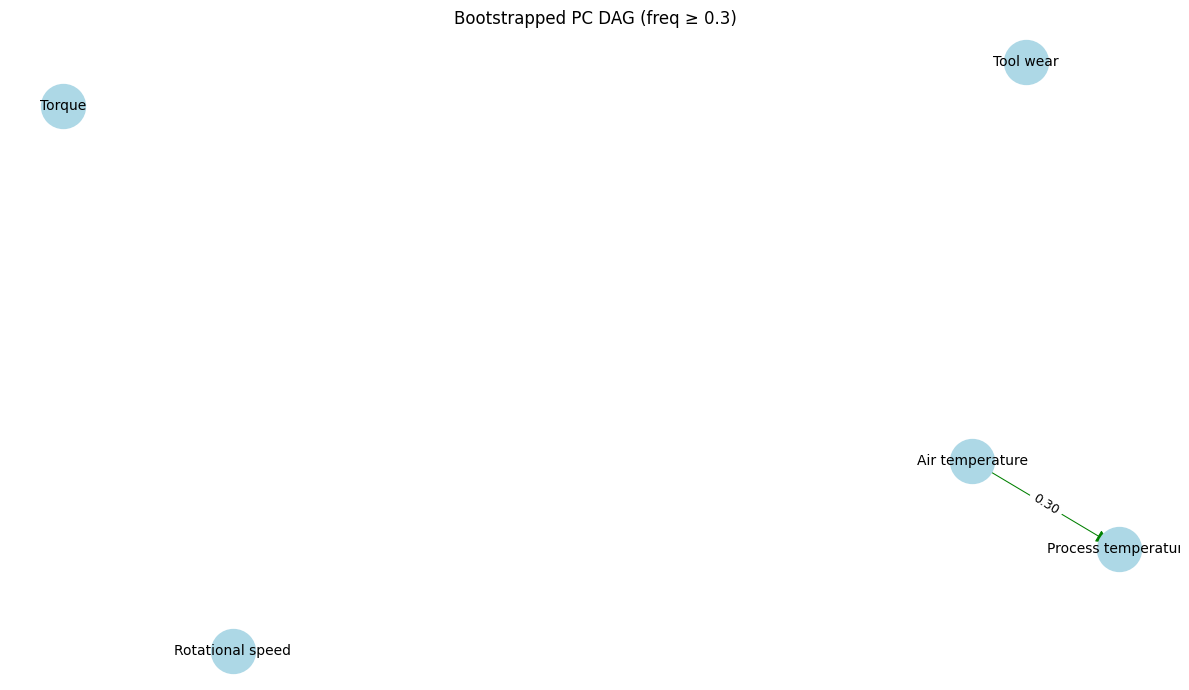

In [21]:
# Cell 9C – Visualize Bootstrapped PC DAG

import matplotlib.pyplot as plt
import networkx as nx

ALG_NAME = "PC_Bootstrap"
G = results_graph.get(ALG_NAME)

if G is None:
    print(f"Cannot visualize – no graph found for {ALG_NAME}")
else:
    min_freq_display = 0.3

    edges_to_draw = [
        (u, v) for u, v, d in G.edges(data=True)
        if d.get("freq", 0) >= min_freq_display
    ]

    if not edges_to_draw:
        print(f"⚠ No edges above freq ≥ {min_freq_display}")
    else:
        # Assign edge colors based on sign
        edge_colors = [
            "green" if G[u][v].get("corr", 0) >= 0 else "red"
            for u, v in edges_to_draw
        ]
        edge_widths = [
            2.5 * G[u][v].get("freq", 0.5)
            for u, v in edges_to_draw
        ]
        edge_labels = {
            (u, v): f'{G[u][v]["freq"]:.2f}'
            for u, v in edges_to_draw
        }

        # Layout
        pos = nx.spring_layout(G, seed=42)

        # Plot
        plt.figure(figsize=(12, 7))
        nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="lightblue")
        nx.draw_networkx_labels(G, pos, font_size=10)

        nx.draw_networkx_edges(
            G, pos,
            edgelist=edges_to_draw,
            edge_color=edge_colors,
            width=edge_widths,
            arrows=True,
            arrowsize=20
        )

        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

        plt.title(f"Bootstrapped PC DAG (freq ≥ {min_freq_display})")
        plt.axis("off")
        plt.tight_layout()
        plt.show()


In [105]:
# Cell 10: Compare Edges Across Algorithms 

import os
import pandas as pd
from glob import glob

# A) Find all FINAL_edges_*.csv files
edge_files = sorted(glob(os.path.join(OUT_DIR, "**", "FINAL_edges_*.csv"), recursive=True))
print(f"Found {len(edge_files)} edge files.")

# B) Load each file safely
edge_sets = {}
skipped = []

for fpath in edge_files:
    alg_name = os.path.basename(fpath).replace("FINAL_edges_", "").replace(".csv", "")
    try:
        df = pd.read_csv(fpath)
        if df.shape[0] == 0 or "source" not in df.columns or "target" not in df.columns:
            skipped.append((alg_name, "empty or invalid"))
            continue
        df["edge"] = df["source"] + " → " + df["target"]
        edge_sets[alg_name] = set(df["edge"])
    except Exception as e:
        skipped.append((alg_name, str(e)))

# C) Build comparison table
all_edges = sorted(set().union(*edge_sets.values()))
alg_names = sorted(edge_sets.keys())

comparison_df = pd.DataFrame(index=all_edges, columns=alg_names, dtype=int).fillna(0)
for alg, edges in edge_sets.items():
    comparison_df[alg] = comparison_df.index.isin(edges).astype(int)

# D) Save results
cmp_path_csv = os.path.join(OUT_DIR, "EDGE_COMPARISON_TABLE.csv")
comparison_df.to_csv(cmp_path_csv)
print("Saved edge comparison table:", cmp_path_csv)

# E) Show shared edges
shared = comparison_df[comparison_df.sum(axis=1) > 1]
print(f"\nEdges shared by ≥2 algorithms: {len(shared)}")
print(shared.sort_values(by=alg_names, ascending=False).head(10))

# F) Report skipped
if skipped:
    print(f"\n Skipped {len(skipped)} files:")
    for alg, reason in skipped:
        print(f"  - {alg}: {reason}")


Found 45 edge files.
Saved edge comparison table: outputs_step2/EDGE_COMPARISON_TABLE.csv

Edges shared by ≥2 algorithms: 20
                                       DAG-GNN  DAG-GNN_Bootstrap  \
Air temperature → Process temperature        1                  1   
Process temperature → Tool wear              1                  1   
Rotational speed → Tool wear                 1                  1   
Torque → Tool wear                           1                  1   
Torque → Rotational speed                    0                  1   
Process temperature → Air temperature        0                  1   
Air temperature → Rotational speed           0                  1   
Rotational speed → Air temperature           0                  1   
Rotational speed → Torque                    0                  1   
Air temperature → Tool wear                  0                  1   

                                       DAGGNN_Bootstrap  LiNGAM  \
Air temperature → Process temperature           

In [108]:
# Cell 11A: Build Per-Algorithm Summary JSONs 

import json

SUMMARY_DIR = os.path.join(OUT_DIR, "algorithm_summaries")
os.makedirs(SUMMARY_DIR, exist_ok=True)

summary_files = {}

# Load comparison table
cmp_df = pd.read_csv(cmp_path_csv, index_col=0)

for alg in cmp_df.columns:
    alg_edges = cmp_df[alg][cmp_df[alg] == 1].index.tolist()
    total_edges = len(alg_edges)
    
    # Count shared edges
    shared_count = cmp_df.loc[alg_edges].sum(axis=1).gt(1).sum()

    # Try loading algorithm edge file to get weight info
    fpath = os.path.join(OUT_DIR, f"FINAL_edges_{alg}.csv")
    try:
        df = pd.read_csv(fpath)
        df["edge"] = df["source"] + " → " + df["target"]
        df = df[df["edge"].isin(alg_edges)]
        if "abs_weight_median" in df.columns:
            df = df.sort_values("abs_weight_median", ascending=False)
        top_edges = df["edge"].head(5).tolist()
    except:
        top_edges = alg_edges[:5]  # fallback if no file

    # Build clean JSON-safe summary
    summary = {
        "algorithm": alg,
        "total_edges": int(total_edges),
        "shared_with_others": int(shared_count),
        "top_5_edges": list(top_edges),
        "params": {
            "K_RUNS": int(K_RUNS),
            "SAMPLE_FRAC": float(SAMPLE_FRAC),
            "FREQ_THR": float(FREQ_THR),
            "EDGE_Q": float(EDGE_Q),
            "BOOTSTRAP": bool(BOOTSTRAP),
        }
    }

    out_json = os.path.join(SUMMARY_DIR, f"SUMMARY_{alg}.json")
    with open(out_json, "w") as f:
        json.dump(summary, f, indent=2)
    summary_files[alg] = out_json

print(f"Saved {len(summary_files)} per-algorithm summaries in:\n{SUMMARY_DIR}")


Saved 8 per-algorithm summaries in:
outputs_step2/algorithm_summaries


In [109]:
# Cell 11B: Build LLM_input.json 
import json

LLM_JSON = os.path.join(OUT_DIR, "LLM_input.json")

# Load per-alg summaries
alg_summaries = []
for f in summary_files.values():
    with open(f, "r") as fp:
        alg_summaries.append(json.load(fp))

# Load comparison matrix
cmp_df = pd.read_csv(cmp_path_csv, index_col=0)
cmp_dict = cmp_df.to_dict(orient="index")

# Global metadata
llm_input = {
    "project": "Causal Discovery Pipeline",
    "total_algorithms": len(alg_summaries),
    "global_params": {
        "K_RUNS": int(K_RUNS),
        "SAMPLE_FRAC": float(SAMPLE_FRAC),
        "FREQ_THR": float(FREQ_THR),
        "EDGE_Q": float(EDGE_Q),
        "BOOTSTRAP": bool(BOOTSTRAP),
    },
    "algorithms": alg_summaries,
    "edge_comparison_matrix": cmp_dict,
}

# Save
with open(LLM_JSON, "w") as f:
    json.dump(llm_input, f, indent=2)

print(f"Master summary saved to: {LLM_JSON}")


Master summary saved to: outputs_step2/LLM_input.json
